# Flood area Segmentation

Einteilung in Überschwemmungsgebiet (Wasserbereiche auf den Bildern zuverlässig erkennt) - oder nicht.

## Daten
Daten von Kaggle: https://www.kaggle.com/code/faizalkarim/flood-area-segmentation

Datensatz enthält 290 Bilder von überschwemmten Gebieten sowie die dazugehörigen Maskenbilder, die die Wasserflächen markieren. -> Die Masken wurden mit der Open-Source-Software Label Studio erstellt.

### Anwendung des Modells:
Für Überschwemmungsanalysen, bessere Entscheidungen und Planung.

Allerdigns: Aufgrund der geringen Datenmenge sollten vortrainierte Modelle und Datenaugmentation genutzt werden.

### Struktur des Datensatzes:
- Image/: Ordner mit allen Überschwemmungsbildern
- Mask/: Ordner mit den entsprechenden Maskenbildern
- metadata.csv: CSV-Datei, die Bildnamen mit Masken verknüpft

# Modell 1 mit U-Net

## Code
Gefunden auf Kaggle: https://www.kaggle.com/code/ashikshahriar/flood-area-segmentation/notebook

Requirements: GPU (change runtime in this google colab project)

## Laden der Daten und Inspizieren der Daten
https://www.kaggle.com/discussions/general/51898

In [ ]:
import os
import kagglehub
from pathlib import Path

path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")

# access data
base_dir = Path(path)
print('No of images: ', len(os.listdir(base_dir / 'Image')))
print('No of masks: ', len(os.listdir(base_dir / 'Mask')))

No of images:  290
No of masks:  290


So sehen die Daten aus - zum Image gibt es die jeweilige Mask (markierte Wasserflächen)

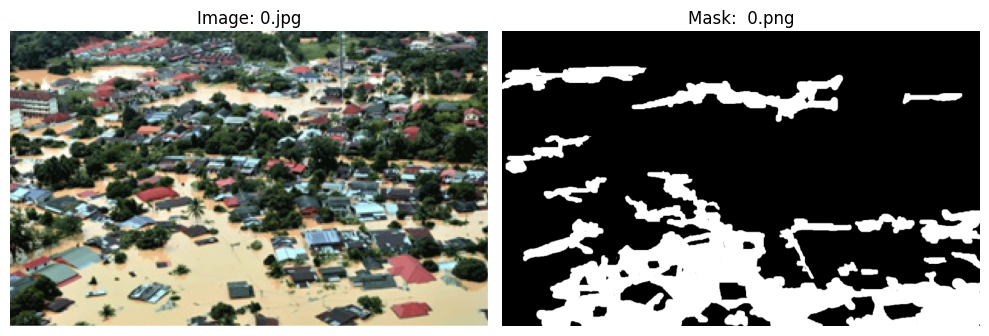

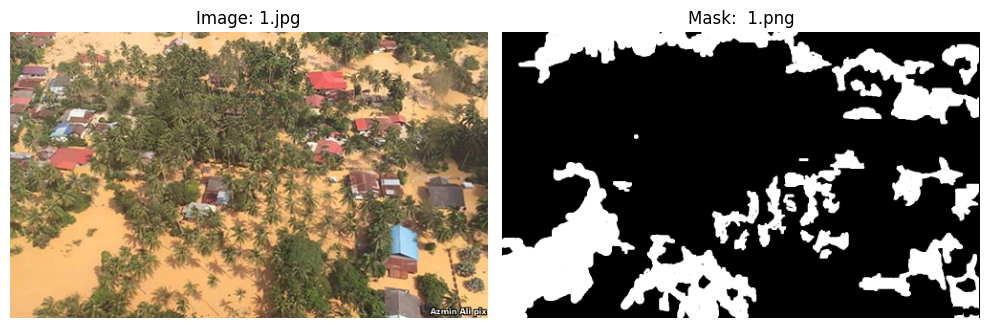

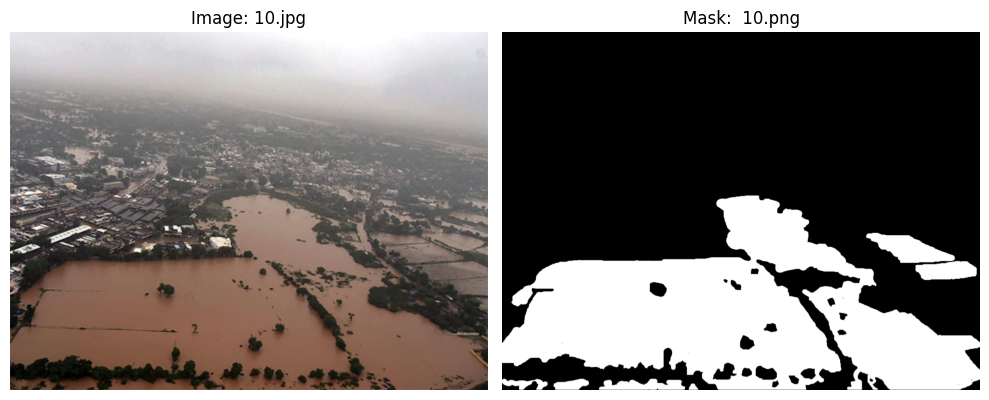

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image_files = sorted(os.listdir(base_dir / 'Image'))
mask_files = sorted(os.listdir(base_dir / 'Mask'))

for i in range(3):

  image = Image.open(base_dir / 'Image' / image_files[i])
  mask = Image.open(base_dir / 'Mask' / mask_files[i])

  # plot
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title(f"Image: {image_files[i]}")
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.title(f"Mask:  {mask_files[i]}")
  plt.imshow(mask, cmap='gray')
  plt.axis('off')

  plt.tight_layout()
  plt.show()

Maske wird über Bild gelegt - Maskierter Bereich wird jetzt rot dargestellt

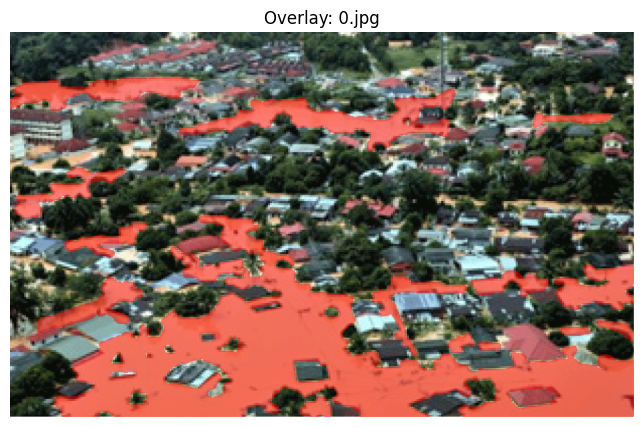

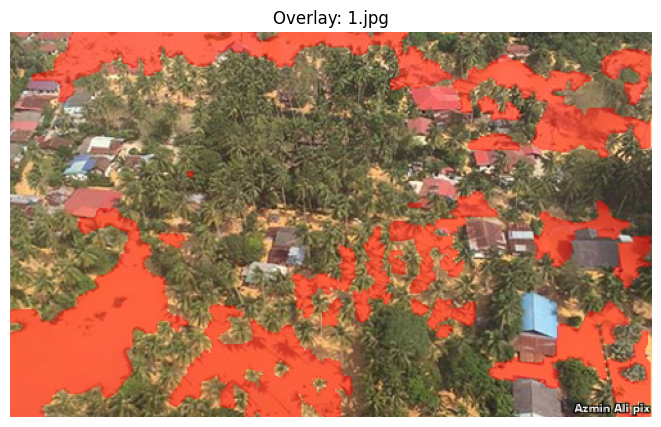

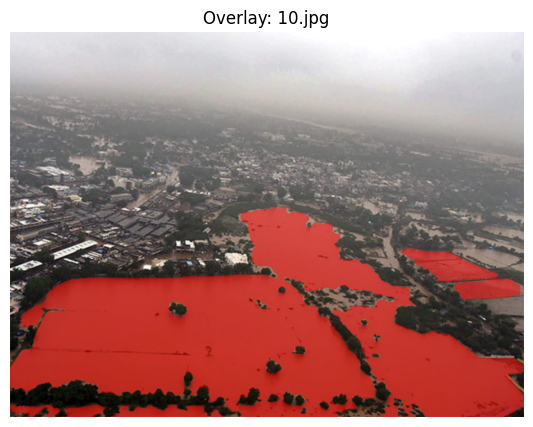

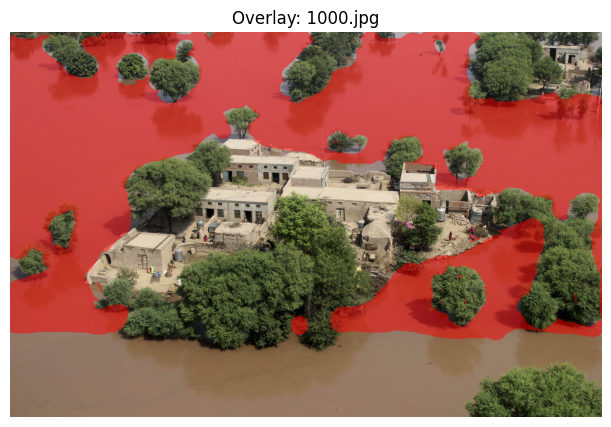

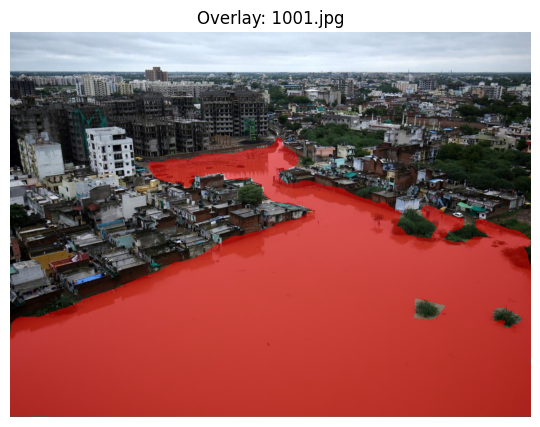

In [ ]:
import numpy as np

image_dir = base_dir / 'Image'
mask_dir = base_dir / 'Mask'

def overlay_mask_on_image(num_images=5, alpha=0.5):

    image_files = sorted(os.listdir(image_dir))[:num_images]
    mask_files = sorted(os.listdir(mask_dir))[:num_images]

    for i, (img_file, mask_file) in enumerate(zip(image_files, mask_files)):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Convert to numpy arrays
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Create overlay by blending image and mask
        overlay = img_np.copy()
        overlay[mask_np > 0] = [255, 0, 0]  # Highlight mask area in red

        blended = (1 - alpha) * img_np + alpha * overlay
        blended = blended.astype(np.uint8)

        # Plot
        plt.figure(figsize=(10, 5))
        plt.title(f"Overlay: {img_file}")
        plt.imshow(blended)
        plt.axis('off')
        plt.show()

# Call the function
overlay_mask_on_image(num_images=5, alpha=0.5)

## Semantic Segmentation

Ziel ist es, aus Satellitenbildern die Wasserflächen exakt herauszufiltern. Also jedem Pixel die Klasse „Wasser“ oder „kein Wasser“ zuzuweisen.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split

### Datenvorbereitung

Bildergröße (Image und Mask) wird auf 224 x 224 pixel skaliert. Image wird in 3-Kanal-Farbe (RGB) umgewandelt. Mask wird in 1-Kanal Graustufen umgewandelt (Schwarz = 0, Weiß = 255).

Normalisierung: Image und Mask bestehen ursprünglich aus Werten 0–255 (8-Bit). /255 ergibt somit Werte zwischen 0 und 1 == Normalisierung.

Gibt das Array zurück: Listen werden in NumPy-Arrays umgewandlet. Keras erwartet eine zusätzliche axis (axis =1) ... sodass wir die Form (224, 224, 1) erhalten

Batch-size: 32 Bilder werden gleichzeitig beim Training in das NN gegeben



In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32

def load_images_and_masks():
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        # Load and resize
        img = Image.open(img_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("RGB")
        mask = Image.open(mask_path).resize((IMG_WIDTH, IMG_HEIGHT)).convert("L")  # Grayscale

        # Normalize image and mask
        images.append(np.array(img) / 255.0)
        masks.append(np.array(mask) / 255.0)

    return np.array(images), np.expand_dims(np.array(masks), axis=-1)

# Load dataset
images, masks = load_images_and_masks()
print(images.shape)
print(f"Loaded {len(images)} images and masks.")

(290, 224, 224, 3)
Loaded 290 images and masks.


### Auteilung in Train und Validation Daten
20 % Validierung ... 58

80 % Training .. 232

In [ ]:
# Train-validation-test split
from sklearn.model_selection import train_test_split

# First split: training set and temporary set (30% goes to temp)
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)

# Second split: divide temp set into validation and test sets (50% each → 15% each of total)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset shapes
print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)

Train: (203, 224, 224, 3)
Val:   (43, 224, 224, 3)
Test:  (44, 224, 224, 3)


In [ ]:
# Import precision, recall, f1_score and IoU Metric

import import_ipynb
from utils.iou import iou_metric
from utils.precision_recall_f1 import precision_metric, recall_metric

#Can not load f1_metric "cannot import name 'f1_metric' from 'utils.precision_recall_f1' (unknown location)", therfore:
import tensorflow as tf
from tensorflow.keras import backend as K
import keras

@keras.saving.register_keras_serializable()
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + K.epsilon())

#### Tensorflow Speicherwachstum erlauben - verhindert Pre-Allocation

Normalerweise versucht TensorFlow beim Start den gesamten verfügbaren GPU-Speicher zu reservieren (auch wenn er noch gar nicht gebraucht wird). 

Mit `set_memory_growth = True` reserviert TensorFlow nur so viel Speicher wie gerade benötigt wird.
Wenn mehr gebraucht wird, wächst die Allokation dynamisch.



In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    u1 = Concatenate()([u1, c3])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model

# Create model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_metric, recall_metric, f1_metric, iou_metric])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 224, 224,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 224, 224,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 112, 112,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 112, 112,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 56, 56,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 56, 56,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 56, 56,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 56, 56,    │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 56, 56,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 112, 112,  │          0 │ conv2d_24[0][0] 

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

### Modelltraining

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=BATCH_SIZE
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 791ms/step - accuracy: 0.5401 - f1_metric: 0.0885 - iou_metric: 0.0504 - loss: 0.6875 - precision_metric: 0.3601 - recall_metric: 0.0679 - val_accuracy: 0.5639 - val_f1_metric: 0.0040 - val_iou_metric: 0.0020 - val_loss: 0.6753 - val_precision_metric: 0.8688 - val_recall_metric: 0.0020
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5593 - f1_metric: 0.0034 - iou_metric: 0.0017 - loss: 0.6637 - precision_metric: 0.6505 - recall_metric: 0.0017 - val_accuracy: 0.6206 - val_f1_metric: 0.2983 - val_iou_metric: 0.1754 - val_loss: 0.5780 - val_precision_metric: 0.8259 - val_recall_metric: 0.1821
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6378 - f1_metric: 0.4591 - iou_metric: 0.3121 - loss: 0.6114 - precision_metric: 0.7679 - recall_metric: 0.4046 - val_accuracy: 0.7053 - val_f1_metric: 0.5662 - val_iou_metric: 0.3949 - val_loss: 0.5543 - val_precision_metric: 0.8221 - val_recall_metric: 0.4318
Epoch 4/50
7/7 ━━━━━━━━

### Modell Evaluieren

Loss-Plot: wie gut das Modell im Laufe der Epochen lernt (Trainings- und Validierungsfehler) - zB Overfitting, wenn der Validierungs-Loss steigt, während der Trainings-Loss sinkt.

Accuracy-Plot: wie genau dein Modell bei der Segmentierung ist – sowohl auf den Trainings- als auch Validierungsdaten. Man erkennt, ob das Modell besser wird und wie stabil die Genauigkeit ist.

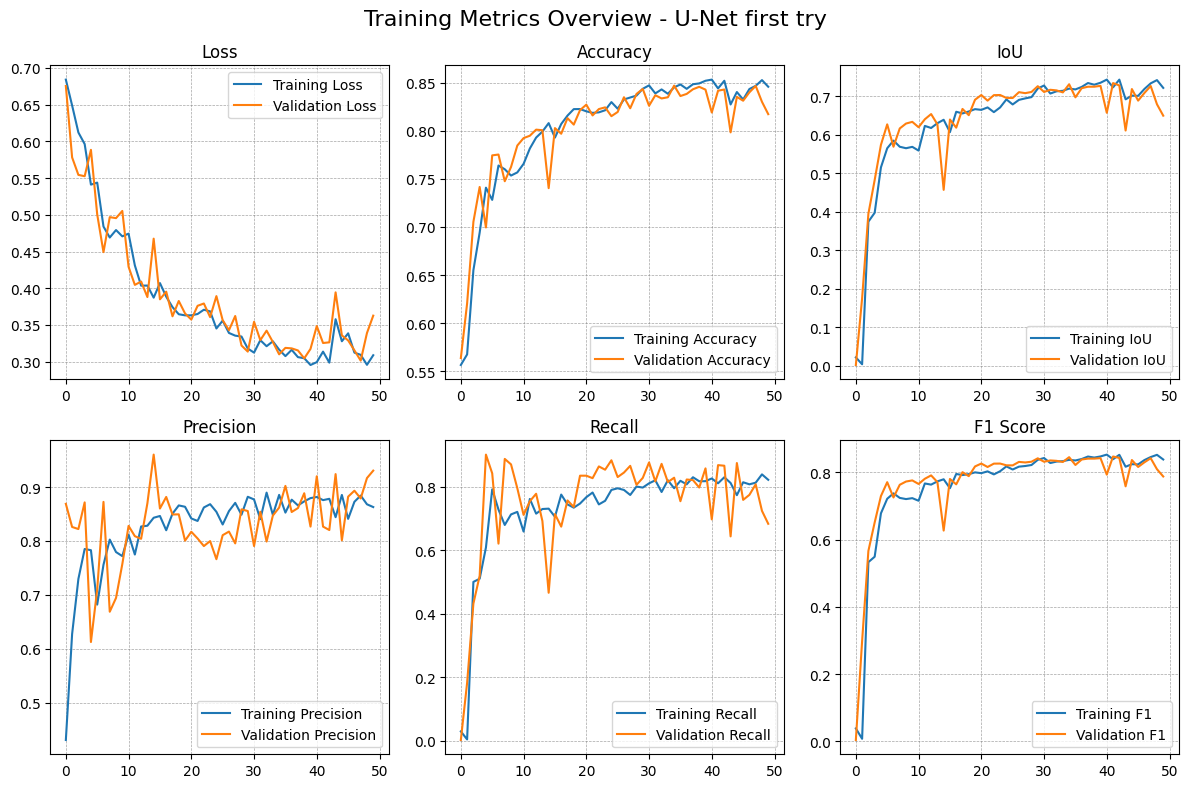

In [ ]:
from datetime import datetime

# Plot training history
# Loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Loss')

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('Accuracy')

#IoU
plt.subplot(2, 3, 3)
plt.plot(history.history['iou_metric'], label='Training IoU')
plt.plot(history.history['val_iou_metric'], label='Validation IoU')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color
plt.title('IoU')

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision_metric'], label='Training Precision')
plt.plot(history.history['val_precision_metric'], label='Validation Precision')
plt.title('Precision')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall_metric'], label='Training Recall')
plt.plot(history.history['val_recall_metric'], label='Validation Recall')
plt.title('Recall')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

# F1 Score
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_metric'], label='Training F1')
plt.plot(history.history['val_f1_metric'], label='Validation F1')
plt.title('F1 Score')
plt.legend()
plt.grid(True, 
         linestyle='--',    # Dashed lines
         linewidth=0.5,     # Line width
         alpha=0.7,         # Transparency
         color='gray')      # Color

plt.suptitle('Training Metrics Overview - U-Net first try', fontsize=16)
plt.tight_layout()
plt.savefig(f'./img/training_metrics_first_try_{datetime.now().isoformat()}.png', dpi=300, bbox_inches='tight')
plt.show()

Was sagen uns die Plots:

Loss: Training Loss sinkt -> Modell lernt gut; Validation Loss schwankt leicht (denke dass die 58 Bilder nicht wirklich aussagekräftig sind) aber trotzdem Stabil (in der Nähe des Training Loss und kein auseinanderklaffen) -> kein Overfitting -> nach 50 Epochs bei ca 0.3

Accuracy: Trainings- als auch Validierungsgenauigkeit steigen deutlich und stabil und liegen nahe beinander (also verallgemeinert das Modell gut) -> nach 50 Epochs bei ca. 85%

Modell ist präzise und man erkennt kein Under- oder Overfitting

#### Vorhersagen visualisieren

Man sieht das Predicted Mask etwas verschwommen ist -> 85% Accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step


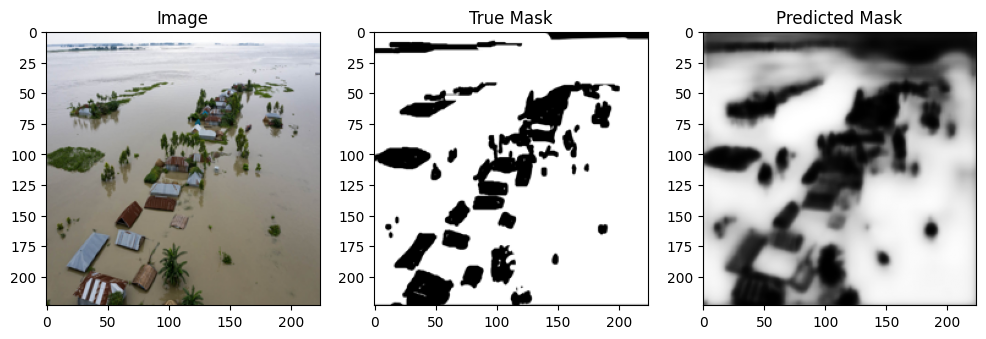

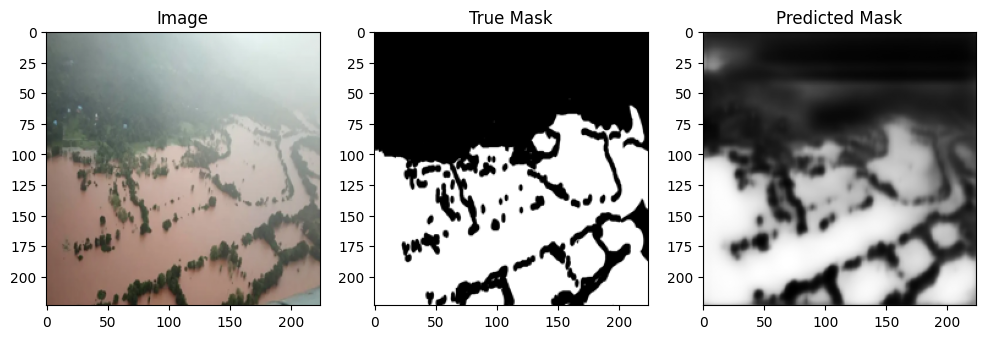

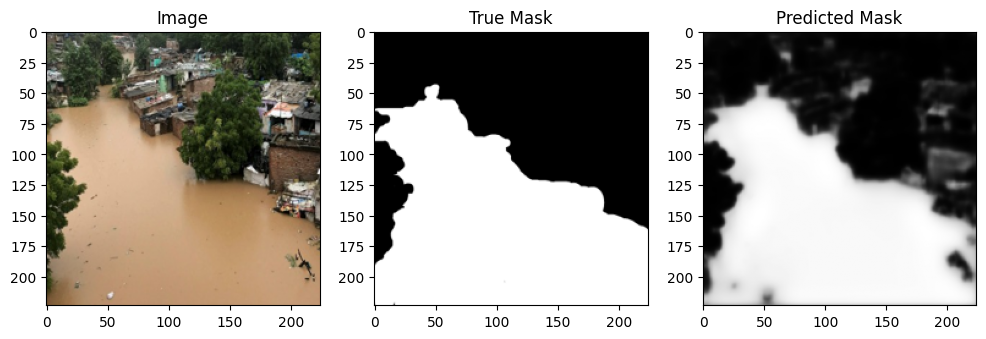

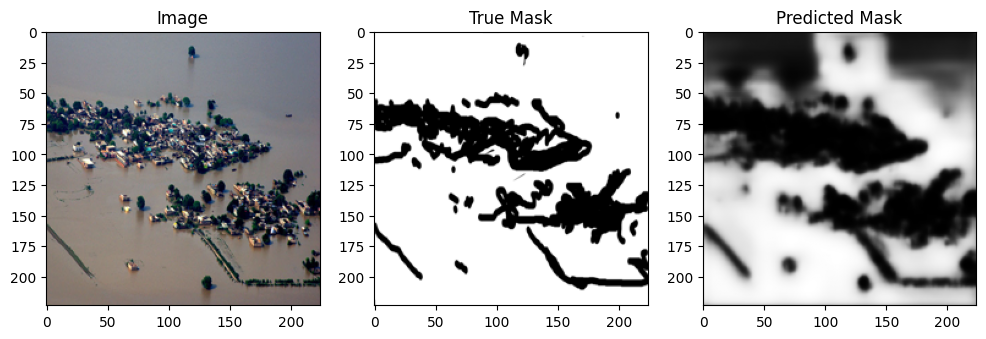

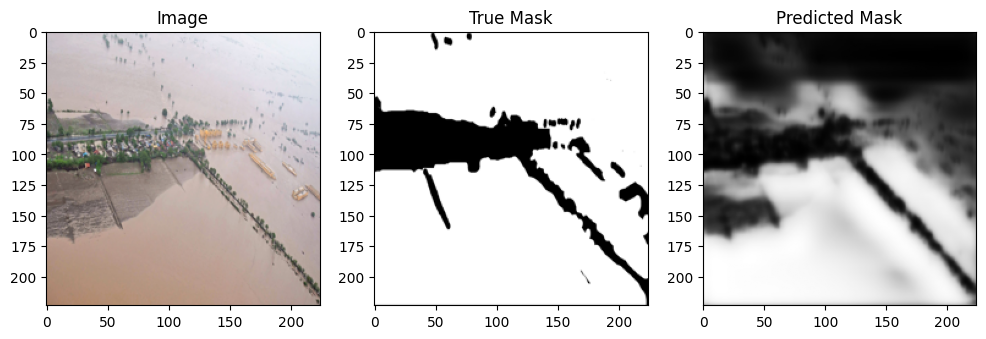

In [ ]:
# Visualize predictions
def visualize_predictions(num_images=5):
    preds = model.predict(X_val[:num_images])

    for i in range(num_images):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(X_val[i])

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(y_val[i].squeeze(), cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(preds[i].squeeze(), cmap='gray')

        plt.show()

visualize_predictions()

### Modell evaluieren mit Testdaten

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Prediction and binarization
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
y_true_binary = (y_test > 0.5).astype(int)

# Flatten
y_true_flat = y_true_binary.flatten()
y_pred_flat = y_pred_binary.flatten()

# Metrics
precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat)
iou = jaccard_score(y_true_flat, y_pred_flat)

# Output
print("\n===== Final Test Evaluation =====")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step

===== Final Test Evaluation =====
Precision: 0.9340
Recall:    0.6645
F1 Score:  0.7765
IoU:       0.6347


Precision 92,62%: von allen überfluteten/Wasser Pixel warend soviele tatsächlich korrekt -> hohe Präzision (wenig falsche positive Vorhersagen)

Recall 66,13 %: non allen tatsächlich positiven Pixeln hat das Modell 66,13 % korrekt erkannt -> mittelmäsig, da einige überflutete Bereiche nicht erkannt werden (also falsche negative) 

F1 Score 77,17 %: Mittel von Precision und Recall -> Wert ist gut

IoU 62,82%: Überlappung zwischen vorhergesagter und tatsächlicher Maske -> soviel stimmt von der vorhergesagten Fläche mit der Realität überein. -> Wert ist gut

## Model speichern

In [ ]:
# saves the trained model to the file
model.save('./trained_models/flood_segmentation_model.keras')

# val_accuracy: 0.8501 - val_iou_metric: 0.7154 - val_loss: 0.3139

### Modell und Variablen löschen - Cleanup


In [ ]:
import gc
import tensorflow as tf
from keras import backend as K

# Delete model explicitly
del model
K.clear_session()
tf.keras.backend.clear_session()

del X_train, X_val, y_train, y_val
# garbage collection
gc.collect()

0

### Vorhersagen mit Überschwemmungsbildern aus Österreich
Test ob das gespeicherte Model ist nutzbar

2025-06-09 22:38:46.519278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749508726.537505 2038175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749508726.543139 2038175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749508726.556804 2038175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749508726.556824 2038175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749508726.556825 2038175 computation_placer.cc:177] computation placer alr

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1749508732.739566 2038476 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


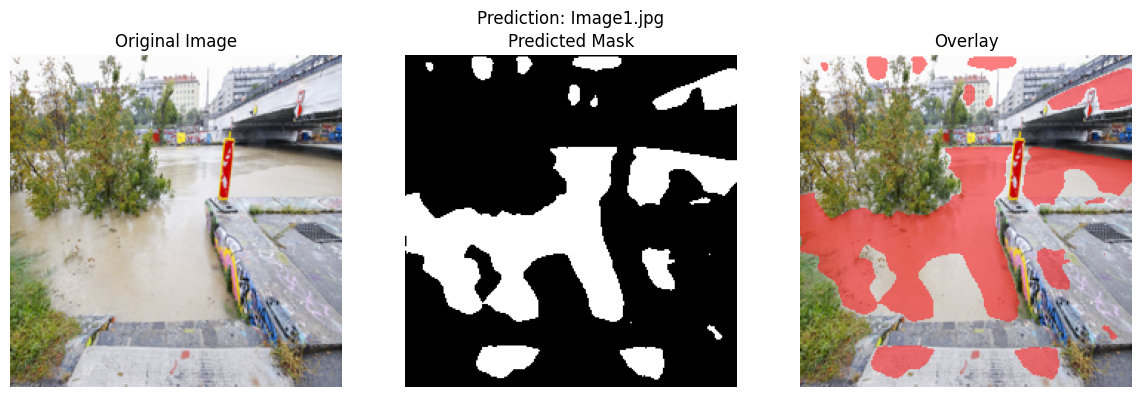

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


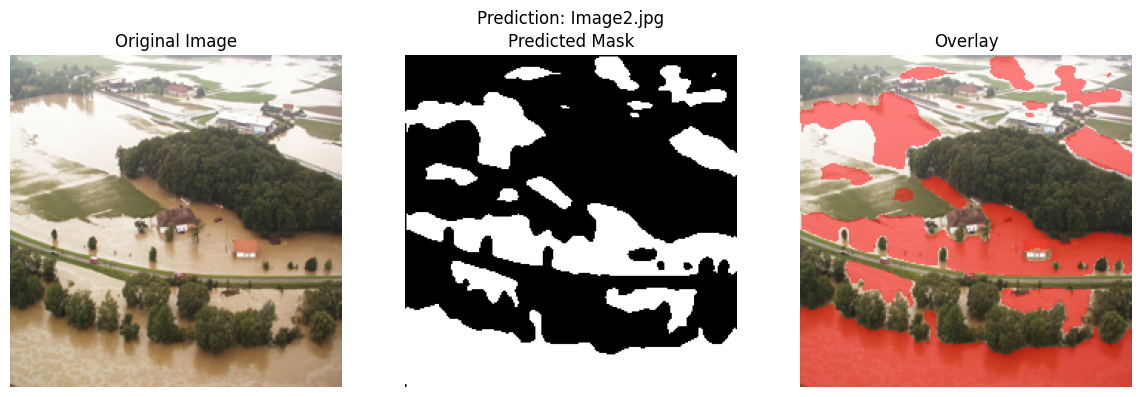

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


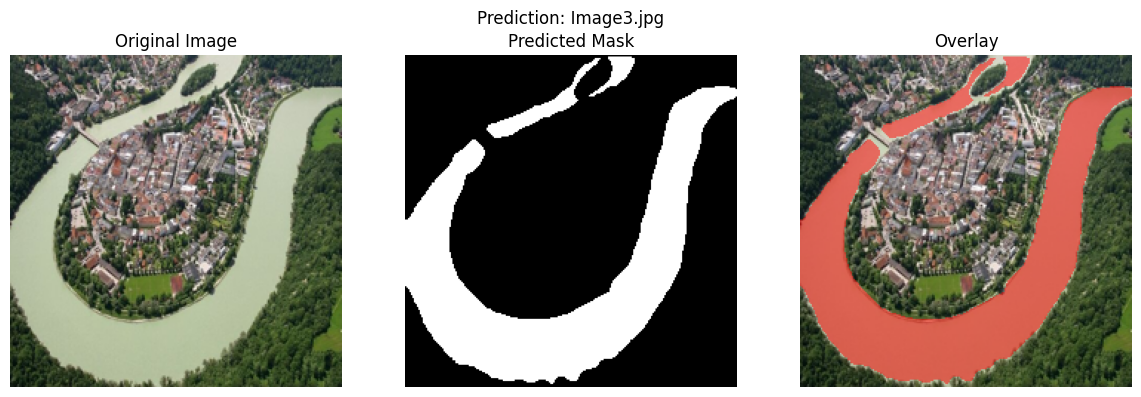

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


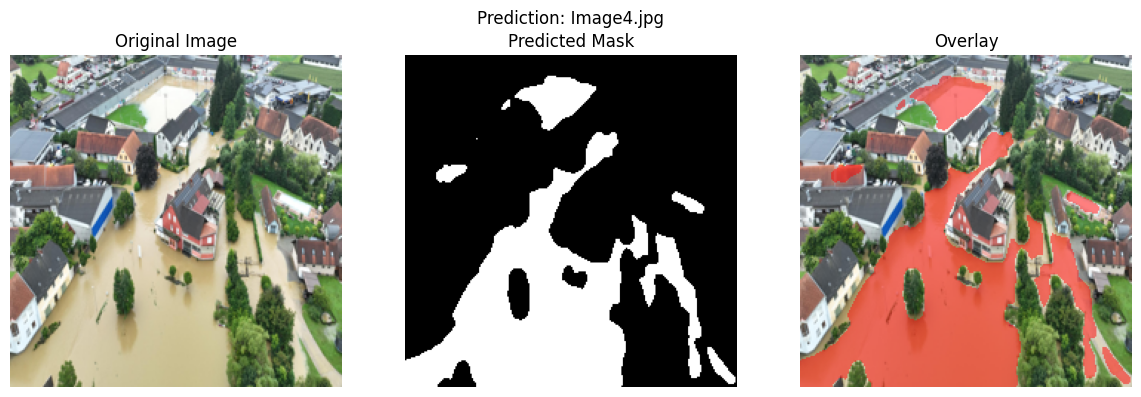

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


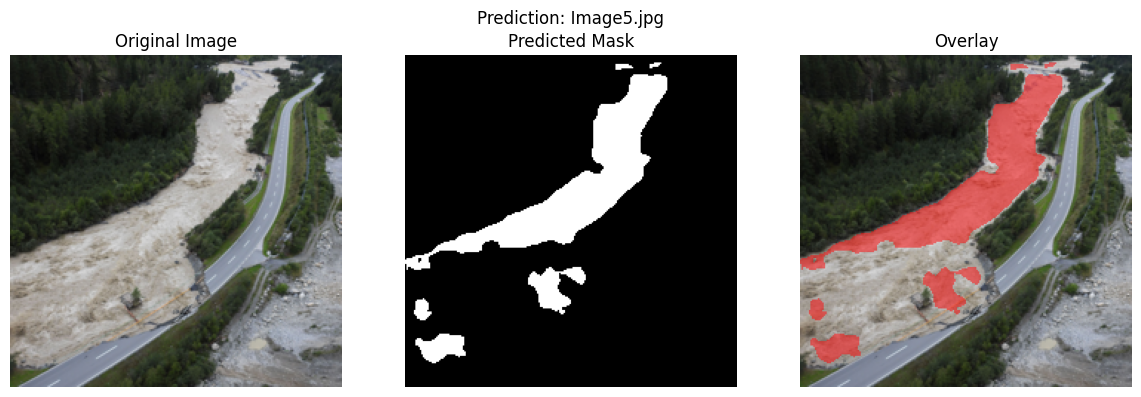

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


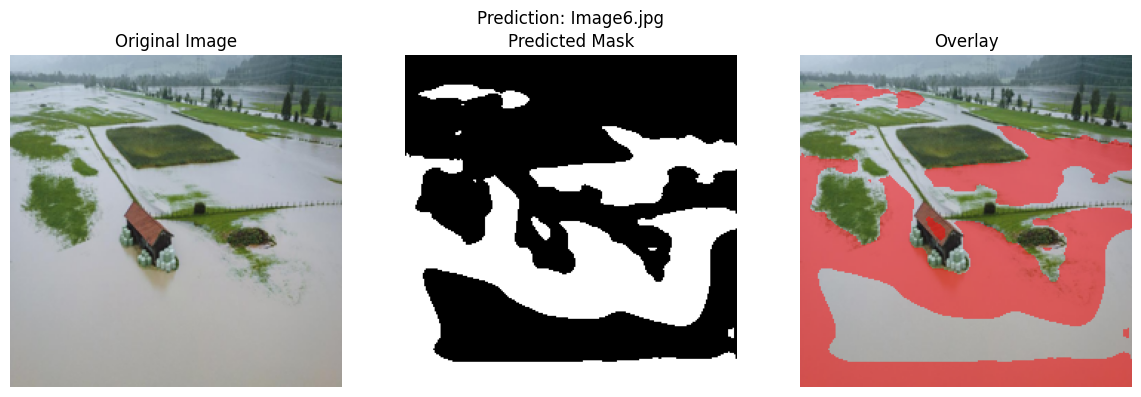

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


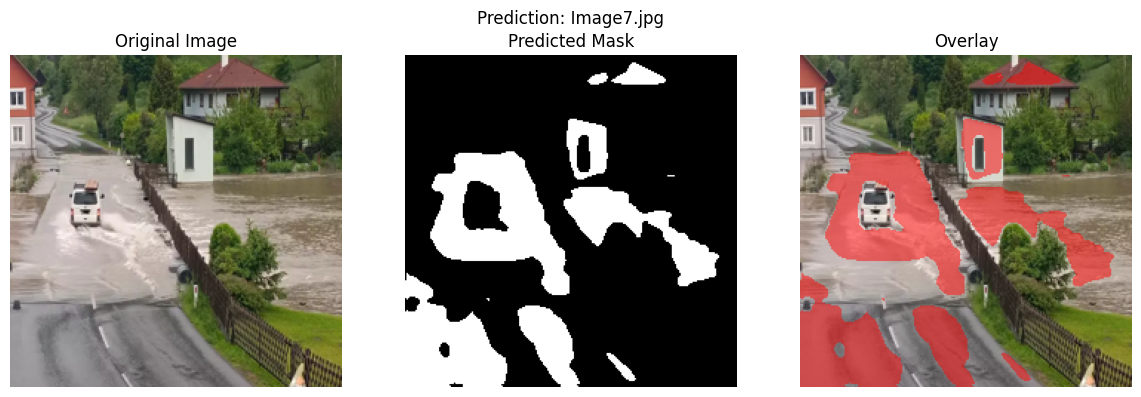

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


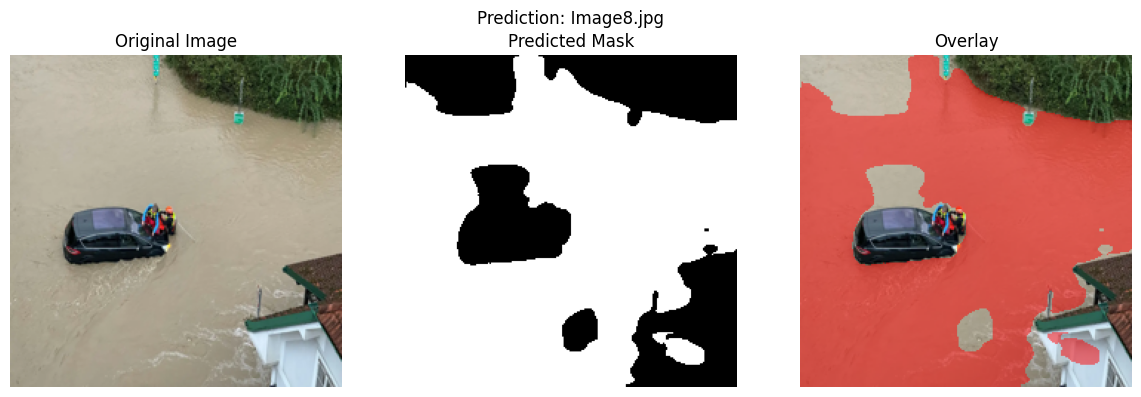

In [1]:
import import_ipynb
from utils.visualize_prediction import visualize_prediction
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.models import load_model

IMG_HEIGHT, IMG_WIDTH = 224, 224
IMAGE_FOLDER = 'flood_images'  
ALPHA = 0.5  # Transparency of the mask

# load the model
model = load_model('./trained_models/flood_segmentation_model.keras', compile=False)

# use images for predictions
image_files = sorted(os.listdir(IMAGE_FOLDER))
for img_file in image_files:
    img_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # preparation
    image = Image.open(img_path).convert("RGB")
    image_resized = image.resize((IMG_WIDTH, IMG_HEIGHT))
    image_array = np.array(image_resized) / 255.0
    input_tensor = np.expand_dims(image_array, axis=0)  # Shape: (1, H, W, 3)

    # prediction
    pred_mask = model.predict(input_tensor)[0, :, :, 0]  # Shape: (H, W)
    pred_binary = (pred_mask > 0.5).astype(np.uint8)

    visualize_prediction(
    image_resized=np.array(image_resized), 
    pred_binary=pred_binary, 
    img_file=img_file,
    alpha=ALPHA
)


## U-NET TODO: Performance des Modells weiter verbessern

- [x] Modell speichern - und außerdem noch mehr performance messungen machen - da hab ich in AIE (discord) auch einen link geteilt, der sich mit performance comparence befasst - vielleicht können wir was daraus entnehmen: https://www.kaggle.com/code/subhojeetroy01/flood-prediction-models-performance-comparison
  - Man kann jetzt mit `save_model` das Modell speichern und mit `load_model` laden
  - In `Data_augmentation.ipynb` wurde Intersection over Union (IoU) Metrik implementiert, die gut für Auswertung von Segmentation geeignet ist.   

- [ ] Wie? Anpassen der Parameter/hyperparameter zb
  - Und von diesem code vielleicht noch was übernehmen: https://www.kaggle.com/code/minhbau/flood-area-segmentation-deeplabv3-58f6e1/notebook

- [x] Add data augmentation: https://www.kaggle.com/code/dhaaivat20/unet-from-scratch
  - `Data_augmentation.ipynb`

[`Data_augmentation.ipynb`](https://colab.research.google.com/drive/1bkgYOLEVnUtxBD4WDqfA0yjWMbLgs7az?usp=sharing)


##### Übung 28.05.2025 -> TODOs:

ML-Pipeline: Business Probelm führt zu
- [x] Goal definition
- [x] DataCollection & preparation -> da ist ihnen wichtig dass wir - auch selbst daten labeln
- [x] Feature engineering -> das ist bei cnn nicht wirklich zu machen (bei uns ist data augmentation - gehört aber zu data preparation .... Filter drüberlegen usw machen CNN eh selber) - beispiel
- [x] Model training -> 1 Iteration trainieren und messern reicht nicht (Modell verbessern durch Feature engineering und data collection & preparation ändern (also schaun ob labeling passt) usw) -> auch Nachweis bringen dass Modell mit neuen (also unkenannten) Daten funktioniert (performance halten kann)
- [ ] Model evaluation
- [ ] Model deployment
- [ ] Model serving
- [ ] Model monitoring
- [ ] Model maintenance

Generell:

- Metriken überlegen und auch beschreiben warum sie für Bild Segmentierung gut sind

- auch selbständig Daten labeln (also bei uns die mask)

- ML-Pipeline -> dann für predictions eigene Bilder (google) verwenden und dann schaun ob es trotzdem nocht gut performt -> zb mit overlay von orig bild und predicted mask (dann sieht man zumindest visuell wie das funktioniert)

- Grafiken genererien die Code/Modell zeigen

- was sind unsere Schlüsse daraus

- beim nächsten Termin 10.06.2025 herzeigen, was wir schon gemacht haben

-> workflow
- mit Daten vertraut machen, visualisieren und anschaun
- Modell trainiert und Ergebnisse anschaut - und verbessern 1.Modell Daten anpassen, 2. Modell dann zb Hyperparameter (zb Learning rate) anpassen
- WElche Trainingsstrategien sind notwendig um Modell robust zu machen
- Deployment ist nicht so wichtig (aber ich denk das soll nur theoretisch durchgegangen werden)
- wichtig ist dieser iterativer Prozess -> neue Schichten einfügen, Normalisierung + Lernrate anpassen -> dann auch verstehen was die Änderungen bewirken usw.
- Vergleich von Werten (zb F1 score) mit anderen Arbeiten
- Effekt beschreiben, wenn ich Hyperparameter anpasse

CNN:
Stride = Schritweite bei CNN (also wie Filter angewendet wird) - zero Padding = damit die Größe des inputs gleich bleibt (am Rand werden die zeros hinzugefügt damit schließlich wieder output selbe Größe hat

Wenn man sich die ARchitetur anschaun will von cnn zb
- tensorspace

# Modell 2 mit pretrained YOLO

## Theory
 - Understanding YOLOv8: https://medium.com/@melissa.colin/yolov8-explained-understanding-object-detection-from-scratch-763479652312
 - Slightly more detailed: https://medium.com/@vindyalenawala/yolov8-architecture-a-detailed-overview-5e2c371cf82a
 - Architecture of YOLOv8: https://arxiv.org/html/2408.15857v1#:~:text=The%20architecture%20of%20YOLOv8%20is%20structured%20around,minimize%20computational%20overhead%20while%20retaining%20representational%20power.
 - CSPNet: https://arxiv.org/pdf/1911.11929v1
 - offizielle YOLOv8: https://yolov8.org/yolov8-architecture/

## Flood Area Segmentation mit YOLO und SAM

Wir haben den Code in Kaggle gefunden: https://www.kaggle.com/code/myoungjinson/flood-area-segmentation/notebook#YOLOv8



In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

Daten laden (gleich wie in Modell 1 von Kaggle) und Datensatzprüfung


In [ ]:
import kagglehub
from pathlib import Path

# collect data
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
base_dir = Path(path)

# create directory structure
for subset in ['train', 'val']:
    os.makedirs(f"dataset/images/{subset}", exist_ok=True)
    os.makedirs(f"dataset/labels/{subset}", exist_ok=True)

# image und mask paths
image_dir = base_dir / "Image"
mask_dir = base_dir / "Mask"

image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

img_paths = [image_dir / f for f in image_files]
mask_paths = [mask_dir / f for f in mask_files]

#### Datenvorbereitung

Split in Train und Validation

In [ ]:
import shutil

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    img_paths, mask_paths, test_size=0.2, random_state=42
)

# copy in directories
for img, mask in zip(train_imgs, train_masks):
    shutil.copy(img, f"dataset/images/train/{img.name}")
    shutil.copy(mask, f"dataset/labels/train/{mask.stem}.png")

for img, mask in zip(val_imgs, val_masks):
    shutil.copy(img, f"dataset/images/val/{img.name}")
    shutil.copy(mask, f"dataset/labels/val/{mask.stem}.png")

print("dataset/images/train:", len(os.listdir("dataset/images/train")))
print("dataset/labels/train:", len(os.listdir("dataset/labels/train")))
print("dataset/images/val:  ", len(os.listdir("dataset/images/val")))
print("dataset/labels/val:   ", len(os.listdir("dataset/labels/val")))

dataset/images/train: 232
dataset/labels/train: 232
dataset/images/val:   58
dataset/labels/val:    58


Masken müssen wir für YOLO in text files umwandeln

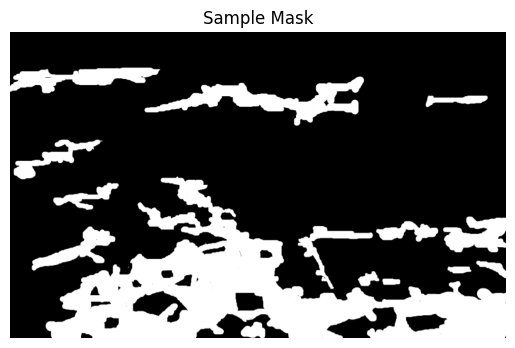

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

example_mask = Image.open("dataset/labels/train/0.png")
plt.imshow(example_mask, cmap='gray')
plt.title("Sample Mask")
plt.axis("off")
plt.show()

In [ ]:
import numpy as np

def mask_to_yolo_txt(mask_path, txt_path, class_id=0):
    mask = cv2.imread(str(mask_path), 0)
    if mask is None:
        print(f"Failed to read {mask_path}")
        return False

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        print(f"No contours found in {mask_path}")
        return False
    h, w = mask.shape

    with open(txt_path, "w") as f:
        for contour in contours:
            if len(contour) < 3:
                continue
            contour = contour.squeeze()
            norm = contour / [w, h]
            norm = norm.flatten()
            norm = ' '.join(map(str, norm))
            f.write(f"{class_id} {norm}\n")

    return True


for subset in ['train', 'val']:
    mask_dir = Path(f"dataset/labels/{subset}")
    for mask_path in mask_dir.glob("*.png"):
        txt_path = mask_path.with_suffix(".txt")  # same folder, same name
        success = mask_to_yolo_txt(mask_path, txt_path)
        if success:
            os.remove(mask_path)  # only remove PNG if txt was created
        else:
            if txt_path.exists():
                os.remove(txt_path)  # remove empty or invalid txt


example_txts = list(Path("dataset/labels/val").glob("*.txt"))
if example_txts:
    print(f"\nSuccessfully created: {example_txts[0]}")
    with open(example_txts[0], "r") as f:
        print("Example content:\n", f.read())
else:
    print("No YOLO label files found.")


print("Train labels:", len(os.listdir("dataset/labels/train")))
print("Val labels:  ", len(os.listdir("dataset/labels/val")))


Successfully created: dataset/labels/val/1021.txt
Example content:
 0 0.06790123456790123 0.12991898148148148 0.06770833333333333 0.13020833333333334 0.06732253086419752 0.13020833333333334 0.07156635802469136 0.13020833333333334 0.07175925925925926 0.12991898148148148
0 0.5040509259259259 0.0 0.5040509259259259 0.00028935185185185184 0.5042438271604939 0.0005787037037037037 0.5042438271604939 0.0008680555555555555 0.5044367283950617 0.0011574074074074073 0.5044367283950617 0.0014467592592592592 0.5046296296296297 0.001736111111111111 0.5046296296296297 0.002025462962962963 0.5048225308641975 0.0023148148148148147 0.5048225308641975 0.0028935185185185184 0.5050154320987654 0.00318287037037037 0.5050154320987654 0.003761574074074074 0.5052083333333334 0.004050925925925926 0.5052083333333334 0.004629629629629629 0.5054012345679012 0.004918981481481482 0.5054012345679012 0.005787037037037037 0.5055941358024691 0.006076388888888889 0.5055941358024691 0.006944444444444444 0.505787037037037

jetzt ein data.yaml erstellen

In [ ]:
import yaml

data_yaml = {
    'path': 'dataset',                  # root directory
    'train': 'images/train',            # relative to dataset/
    'val': 'images/val',                # relative to dataset/
    'nc': 1,                            # number of classes
    'names': ['flood']                  # list of class names
}

with open('data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

!cat data.yaml

names:
- flood
nc: 1
path: dataset
train: images/train
val: images/val


## YOLOv8

https://medium.com/@melissa.colin/yolov8-explained-understanding-object-detection-from-scratch-763479652312

steht für "You Only Look Once" -> für schnelle Inferenzzeiten

wird hier für Segementierung und Objektlokalisierung verwendet -> YOLOv8 ermöglicht Pixel-genaue Masken vorhersagen (vergleichbar mit U-NET, aber zusätzlich mit Objektdetektion)

trainiert wird mit der Library ultralytics; außerdem wird hier ein vortrainiertes Modell geladen und verwendet (verfeinert) -> YOLO("yolo11n-seg.yaml").load("yolo11n.pt")

### Architektur

![U-Net Architektur](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*frzqTxCGA8DHEHMeHug7JQ.png)

#### Backbone – Merkmalsextraktion

Das Backbone extrahiert grundlegende Merkmale wie Kanten, Formen und Texturen aus dem Eingabebild. YOLOv8 verwendet eine modifizierte CSPDarknet53-Architektur, die folgende Techniken kombiniert:

- Convolutional Layers: für Merkmalsextraktion
- Residual Blocks: verhindern den Informationsverlust in tiefen Netzen
- CSPNet (Cross Stage Partial Networks): reduziert Rechenaufwand und verbessert den Gradientendurchfluss
- Darknet53 / CSPDarknet53: als Grundlage des Feature-Backbones

#### Neck – Merkmalsfusion auf mehreren Skalen

Der Neck kombiniert Merkmale unterschiedlicher Auflösung (also unterschiedlicher Conv Layer zB) und verwendet:

- FPN (Feature Pyramid Networks): verarbeitet Bildinformationen auf verschiedenen Skalen
- PANet (Path Aggregation Network): verbessert den Informationsfluss zwischen Ebenen, besonders für kleinere Objekte

Die Feature-Maps (zB P3, P4, P5) werden auf verschiedenen Ebenen zusammengeführt, um die Erkennung von Objekten unterschiedlicher Größe zu ermöglichen.

#### Head – Erkennung & Klassifikation

Der Head erzeugt:

- Bounding Boxes
- Konfidenzwerte
- Klassenvorhersagen



In [ ]:
!pip install ultralytics

  Using cached ultralytics-8.3.152-py3-none-any.whl (1.0 MB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached pandas-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached torch-2.7.1-cp311-cp311-manylinux_2_28_x86_64.whl (821.2 MB)
  Using cached opencv_python-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (63.0 MB)
  Using cached torchvision-0.22.1-cp311-cp311-manylinux_2_28_x86_64.whl (7.5 MB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
  Using cached nvidia_cusparselt_cu12-0.6.3-py3-none-manylinux2014_x86_64.whl (156.8 MB)
  Using cached nvidia_cusolver_cu12-11.7.1.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (158.2 MB)
  Using cached sympy-1.14.0-py3-none-any.whl (6.3 MB)
  Using cached nvidia_nvtx_cu1

In [ ]:
from ultralytics import YOLO

from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n-seg.yaml")  # build a new model from YAML
model = YOLO("yolo11n-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolo11n-seg.yaml").load("yolo11n.pt")  # build from YAML and transfer weights

# Train the model with coco8-seg.yaml
results = model.train(data="data.yaml", epochs=100, imgsz=640, batch=8)

100%|██████████| 5.90M/5.90M [00:00<00:00, 50.2MB/s]


100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]

Transferred 499/561 items from pretrained weights


Ultralytics 8.3.152 🚀 Python-3.11.0rc1 torch-2.7.1+cu126 CUDA:0 (NVIDIA A100 80GB PCIe, 81156MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /mnt/nvme/home/aie3/christina/flood-area-segmentation/dataset/labels/train... 231 images, 0 backgrounds, 1 corrupt: 100%|██████████| 232/232 [00:00<00:00, 281.27it/s]

train: /mnt/nvme/home/aie3/christina/flood-area-segmentation/dataset/images/train/0.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'mpo', 'webp', 'tif', 'heic', 'jpg', 'dng', 'jpeg', 'bmp', 'png', 'pfm'}
videos: {'mp4', 'asf', 'm4v', 'gif', 'wmv', 'mpg', 'mov', 'webm', 'avi', 'mkv', 'ts', 'mpeg'}


train: New cache created: /mnt/nvme/home/aie3/christina/flood-area-segmentation/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2115.1±832.7 MB/s, size: 257.3 KB)


val: Scanning /mnt/nvme/home/aie3/christina/flood-area-segmentation/dataset/labels/val... 58 images, 0 backgrounds, 0 corrupt: 100%|██████████| 58/58 [00:00<00:00, 323.05it/s]

val: New cache created: /mnt/nvme/home/aie3/christina/flood-area-segmentation/dataset/labels/val.cache


Plotting labels to /home/aie3/flood-area-segmentation/runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/aie3/flood-area-segmentation/runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.71G      1.569      5.712      2.826      1.587         68        640: 100%|██████████| 29/29 [00:25<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.27s/it]

                   all         58        460    0.00914      0.346     0.0639     0.0277    0.00305      0.115     0.0245    0.00592



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.73G      1.457      3.967      2.248      1.404        111        640: 100%|██████████| 29/29 [00:03<00:00,  9.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


                   all         58        460     0.0983      0.109     0.0359     0.0124     0.0749     0.0913     0.0256    0.00666

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.75G      1.569      3.469      2.009      1.468         78        640: 100%|██████████| 29/29 [00:03<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.48it/s]

                   all         58        460      0.199      0.165     0.0854     0.0364      0.155      0.146     0.0573     0.0165



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.76G      1.591       3.27      1.978      1.489         48        640: 100%|██████████| 29/29 [00:02<00:00,  9.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.61it/s]

                   all         58        460      0.282      0.183      0.125     0.0587      0.269      0.159      0.103     0.0365



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.78G      1.573      3.243      1.878      1.469        120        640: 100%|██████████| 29/29 [00:03<00:00,  9.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.00it/s]

                   all         58        460      0.275      0.239      0.141     0.0667        0.3      0.212      0.128     0.0472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.82G      1.556      3.147      1.836       1.48         74        640: 100%|██████████| 29/29 [00:03<00:00,  9.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.98it/s]

                   all         58        460      0.298       0.25      0.165     0.0736      0.284      0.237      0.139     0.0503



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.84G      1.479      3.002      1.752       1.43         82        640: 100%|██████████| 29/29 [00:02<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.58it/s]

                   all         58        460      0.363      0.207      0.169     0.0775       0.36      0.201      0.156     0.0551



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.86G      1.482      3.015      1.763      1.437        106        640: 100%|██████████| 29/29 [00:02<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.88it/s]

                   all         58        460      0.285      0.257      0.158     0.0651      0.288      0.237      0.148     0.0557



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.87G      1.532      2.941      1.758       1.47         59        640: 100%|██████████| 29/29 [00:02<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]

                   all         58        460      0.322      0.259      0.178     0.0779      0.352      0.198       0.15     0.0484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.89G      1.473      2.929      1.683      1.395        122        640: 100%|██████████| 29/29 [00:03<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  8.45it/s]

                   all         58        460      0.382      0.235      0.205      0.107      0.322      0.228      0.173      0.068



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.91G      1.414      2.828      1.613      1.375         62        640: 100%|██████████| 29/29 [00:02<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.23it/s]


                   all         58        460      0.353      0.248      0.198     0.0909       0.39      0.237      0.193     0.0741

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.92G      1.437      2.865      1.591      1.369         91        640: 100%|██████████| 29/29 [00:02<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.43it/s]


                   all         58        460      0.381      0.307      0.218      0.102      0.352      0.302      0.204     0.0826

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.94G      1.405      2.857      1.631      1.379        104        640: 100%|██████████| 29/29 [00:02<00:00,  9.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


                   all         58        460       0.41       0.25      0.232      0.118      0.388      0.237      0.206     0.0855

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.96G      1.385      2.761      1.575      1.361         84        640: 100%|██████████| 29/29 [00:03<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.05it/s]


                   all         58        460      0.448      0.246      0.215      0.114      0.396       0.25      0.203     0.0866

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.97G      1.336      2.749      1.503      1.333         76        640: 100%|██████████| 29/29 [00:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.38it/s]


                   all         58        460      0.456       0.23       0.22      0.113      0.504      0.191      0.184     0.0748

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.99G      1.362       2.85      1.513      1.349        108        640: 100%|██████████| 29/29 [00:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]

                   all         58        460      0.422      0.259      0.236      0.127      0.404      0.248      0.203     0.0855



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         2G      1.335      2.775      1.466       1.34         76        640: 100%|██████████| 29/29 [00:02<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.35it/s]


                   all         58        460      0.429       0.27      0.246      0.123       0.46      0.267      0.233     0.0907

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.02G      1.369      2.866      1.524      1.362         48        640: 100%|██████████| 29/29 [00:02<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.30it/s]


                   all         58        460      0.389      0.265      0.242      0.129      0.394      0.237       0.21     0.0845

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.04G      1.312      2.667      1.444      1.317         67        640: 100%|██████████| 29/29 [00:02<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.37it/s]

                   all         58        460      0.497      0.274      0.249      0.124      0.451       0.27      0.225     0.0887



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.05G        1.3      2.666      1.435      1.317        104        640: 100%|██████████| 29/29 [00:02<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


                   all         58        460      0.427      0.257      0.244      0.127      0.391      0.257      0.224      0.083

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.07G      1.313      2.694       1.45      1.328        117        640: 100%|██████████| 29/29 [00:03<00:00,  9.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.87it/s]

                   all         58        460      0.346      0.298      0.234      0.125       0.34      0.287      0.216     0.0896



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.08G      1.319      2.743      1.438       1.32         87        640: 100%|██████████| 29/29 [00:02<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.31it/s]


                   all         58        460      0.401      0.315      0.266      0.146      0.371      0.308      0.241      0.101

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.1G      1.289      2.717      1.396      1.326         61        640: 100%|██████████| 29/29 [00:02<00:00, 10.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


                   all         58        460      0.407      0.298      0.236      0.128      0.411      0.283      0.236     0.0975

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.12G      1.287      2.658      1.415      1.306         64        640: 100%|██████████| 29/29 [00:02<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.90it/s]

                   all         58        460      0.462      0.276      0.242      0.132      0.452      0.276      0.228     0.0865



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.13G      1.322      2.664      1.428      1.341         78        640: 100%|██████████| 29/29 [00:02<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]

                   all         58        460      0.423      0.296      0.251       0.13      0.407      0.272      0.217     0.0964



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.15G      1.315      2.667      1.405      1.315         80        640: 100%|██████████| 29/29 [00:02<00:00, 10.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.45it/s]

                   all         58        460      0.412      0.274      0.233      0.115      0.395      0.274      0.216     0.0867



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.16G      1.271      2.686      1.369      1.286         94        640: 100%|██████████| 29/29 [00:02<00:00, 10.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.29it/s]


                   all         58        460      0.485      0.261       0.25      0.125      0.418       0.27      0.219     0.0885

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.18G      1.268      2.609      1.301      1.276        127        640: 100%|██████████| 29/29 [00:07<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  6.97it/s]

                   all         58        460      0.505      0.293      0.275      0.139      0.464      0.274      0.246      0.102



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.2G      1.218      2.627      1.326       1.26        109        640: 100%|██████████| 29/29 [00:04<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  7.29it/s]

                   all         58        460      0.495        0.3      0.288      0.155      0.448      0.278      0.258      0.112



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.21G       1.25      2.524      1.331      1.287         97        640: 100%|██████████| 29/29 [00:03<00:00,  7.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

                   all         58        460      0.417      0.313      0.263      0.148      0.407      0.296       0.24     0.0963



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.23G      1.251      2.608      1.303      1.274         85        640: 100%|██████████| 29/29 [00:02<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]

                   all         58        460      0.406      0.304      0.258      0.143      0.409      0.298      0.247      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.25G      1.285      2.628      1.302      1.279         74        640: 100%|██████████| 29/29 [00:02<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]

                   all         58        460      0.388      0.315       0.27      0.151      0.406      0.291      0.244     0.0982



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.26G      1.265       2.55      1.282      1.286         90        640: 100%|██████████| 29/29 [00:02<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]

                   all         58        460      0.416      0.296      0.268      0.142      0.399      0.278      0.238      0.104



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.28G      1.234      2.624      1.315      1.278         84        640: 100%|██████████| 29/29 [00:02<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.27it/s]


                   all         58        460      0.419       0.32      0.276      0.156      0.406      0.298      0.254      0.112

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.3G      1.233      2.574      1.289      1.258        111        640: 100%|██████████| 29/29 [00:02<00:00, 10.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

                   all         58        460      0.549      0.267      0.275      0.155      0.537      0.274      0.268      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.31G      1.237      2.581      1.271       1.25        102        640: 100%|██████████| 29/29 [00:02<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00, 10.04it/s]

                   all         58        460      0.453      0.277      0.261      0.145      0.489      0.276      0.249      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.33G      1.216      2.546      1.263      1.273         91        640: 100%|██████████| 29/29 [00:02<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.96it/s]

                   all         58        460        0.5      0.309      0.285      0.151      0.481       0.28      0.268      0.115



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.34G      1.204       2.51      1.238      1.274         61        640: 100%|██████████| 29/29 [00:02<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.92it/s]

                   all         58        460      0.489      0.302      0.275      0.148      0.496      0.289      0.258      0.106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.36G      1.157      2.406      1.196      1.229         85        640: 100%|██████████| 29/29 [00:02<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]

                   all         58        460      0.461      0.309       0.28      0.145      0.438      0.295       0.25      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.38G       1.21      2.504      1.225      1.265        110        640:  76%|███████▌  | 22/29 [00:02<00:00, 10.43it/s]

In [ ]:
model.info()

In [ ]:
results

In [ ]:
model.info(verbose=True)

In [ ]:
print(model.model)

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.model.to(device)

summary(model.model, input_size=(1, 3, 640, 640), col_names=["input_size", "output_size", "num_params", "trainable"])


Ergebnis - Validation

In [ ]:
import cv2
import matplotlib.pyplot as plt

# 1. load image
val_image_path = "dataset/images/val/1002.jpg"
img = cv2.imread(val_image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2. load mask
path = kagglehub.dataset_download("faizalkarim/flood-area-segmentation")
base_dir = Path(path)
mask_filename = "1002.png"
mask_path = base_dir / "Mask" / mask_filename
mask = Image.open(mask_path).convert("L")
mask = np.array(mask)

# 3. prediction of model
results = model.predict(source=val_image_path, save=False)
pred_mask = results[0].masks.data[0].cpu().numpy()

# 4. plot
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


# TODO:
Performance messen
- Evaluation metrics: mean average precision (mAP), precision-recall curve (PR curve), and intersection over union (IoU).